<a href="https://colab.research.google.com/github/zaidishz/GNN_XAI_Captum/blob/main/GNN_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining GNN Model Predictions using Captum

Mutagenicity dataset from [TUDatasets](https://chrsmrrs.github.io/datasets/). This dataset consists of 4337 molecule graphs where the task is to predict the molecule mutagenicity.

In [1]:
# Install required packages.
import os
from torch import __version__, tensor
os.environ['TORCH'] = __version__
print(__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import numpy as  np
import itertools
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq
import pandas as pd

2.0.0+cpu


## Loading the dataset

load the dataset (10% of the data as the test split)

In [2]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data
import os

proxy = 'http://webproxy:8080'

os.environ['http_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [3]:
achse_mat = scipy.io.loadmat('C:\\Users\\vedurm01\\PycharmProjects\\ZeMA_ML\\ZeMA_Matlab\\Achse11_Szenario.mat')

trainData = achse_mat['trainData']
train_data_reshaped = []
for counter, val in enumerate(trainData):
    train_data_reshaped += [val[0]]
train_data_reshaped = np.array(train_data_reshaped)
train_data_reshaped = np.swapaxes(train_data_reshaped, 0, 1)

train_target_reshaped = achse_mat['trainTarget'].reshape(-1)

sensor_names = ['Mic', 'Acc_PB', 'Acc_BB', 'Acc_PR', 'Ax_F', 'Pres', 'Vel', 'Act_Curr', 'Mot_Curr_1', 'Mot_Curr_2', 'Mot_Curr_3']

C:\Users\vedurm01\PycharmProjects\GNN_XAI_Captum\venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

## Convert time-series data to torch geometric graph data. 1. Fully connected graph with 55 edges. Each edge has the correlation between the sensors as an attribute. 

## 2. Reduce number of edges by distarding those with a "below average" correlation 

In [5]:
dataset = []
combs = list(itertools.combinations(range(11), 2))
edge_index_perm = tensor(np.array(combs).T)
triu_ind = np.triu_indices(11, k = 1)
N = 2000
Tsig = 1 / 2000.0
seconds = 5
fps = 50
for k, sample in enumerate(train_data_reshaped):
    corr_mat = np.corrcoef(sample)
    corr_vec = np.reshape(corr_mat[triu_ind], (55,-1))
    corr_edge_inds = np.argwhere(np.abs(corr_vec) > np.abs(corr_vec).mean())
    edge_inds = edge_index_perm[:, corr_edge_inds[:,0]]
    offset = []
#     for node_inds in edge_inds.T:
#         d1 = pd.Series(sample[node_inds[0]])
#         d2 = pd.Series(sample[node_inds[1]])
#         rs = [crosscorr(d1, d2, lag) for lag in range(-int(500),int(501), 50)]
#         offset.append(np.floor(len(rs)/2)-np.argmax(rs))

#     edge_attr = np.stack((corr_vec[corr_edge_inds[:,0]].flatten(), np.array(offset)), axis=-1)
    edge_attr = corr_vec[corr_edge_inds[:,0]]
    scaler = StandardScaler()
    array = scaler.fit_transform(sample.T).T
    array_fft = np.abs(fft(array)[:N//2])
    dataset += [Data(edge_index=edge_inds, x=tensor(array_fft), edge_attr= tensor(edge_attr), y=tensor([train_target_reshaped[k]]))]
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]

In [6]:
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

## Visualizing the data


In [101]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

color_list = ['red', 'yellow']
rng = np.random.default_rng()

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    d = dict(g.degree)
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
    widths = [7*np.abs(g[u][v]['edge_attr'])**.5 for u, v in g.edges()]
    nx.draw(g, pos=pos, labels=node_labels, width=.5,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color=rng.choice([t for t in color_list], size=g.number_of_nodes()), node_size=[v * 500 for v in d.values()]
)
    
    nx.draw_networkx_edges(g, pos, width=widths, alpha=0.5)
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red', node_size=[v * 100 for v in d.values()])
    plt.show()


def to_molecule(data):
    g = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])
    for u, data in g.nodes(data=True):
        data['name'] = sensor_names[u]
    return g

In [102]:
import random

data = random.choice([t for t in train_dataset])
print(data)
g = to_molecule(data)

Data(x=[11, 2000], edge_index=[2, 20], edge_attr=[20, 1], y=[1])


## Sample visualization

We sample a single molecule from train_dataset and visualize it

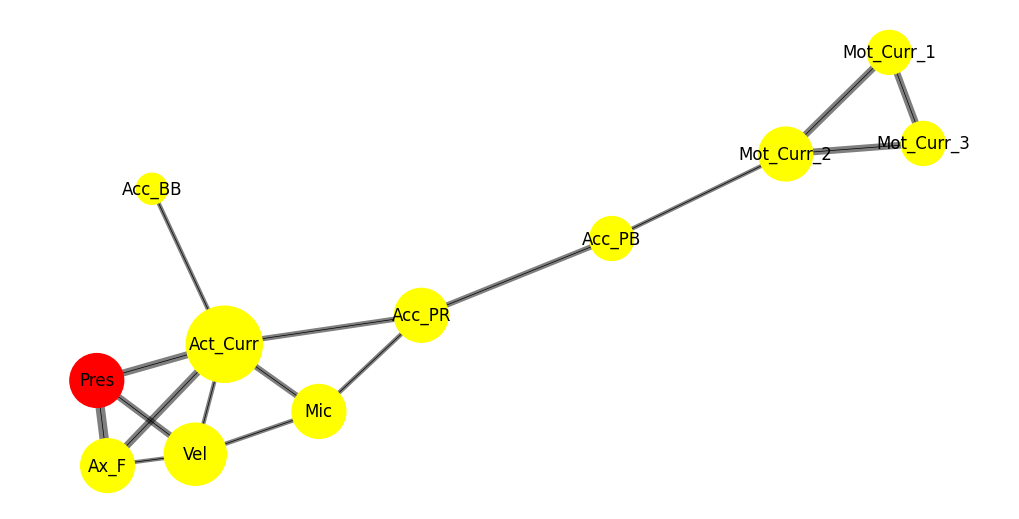

In [103]:
import random

data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [92]:
for u, v in mol.edges():
    print(10*np.abs(mol[u][v]['edge_attr'])**.5)

5.810769461994447
5.715491838991445
4.256387096313503
3.533474176579042
5.120963413653342
9.625024126929166
3.9918052062085554
7.838683773819335
6.641365367308082
7.617575427896435
7.048887577729149
7.099658093266692
7.06325633288885


In [ ]:
T=1/2000.0
N=2000
y = fft(train_data_reshaped[0][0])
xf = fftfreq(N, T)[:N//2]

In [ ]:
plt.plot(xf, 2.0/N * np.real(y[0:N//2]))
plt.plot(xf, 2.0/N * np.imag(y[0:N//2]))

In [ ]:
plt.plot(xf, 2.0/N * np.abs(y[0:N//2]))

In [ ]:
plt.plot(train_data_reshaped[500][7])

In [ ]:
plt.scatter(train_data_reshaped[0][5], train_data_reshaped[0][6])

In [ ]:
np.abs(y[0:N//2]).max() / np.abs(y[0:N//2]).min()

In [ ]:
alldat=[]
for k in range(11):
    T=1/2000.0
    N=2000
    y = fft(train_data_reshaped[0][k])
#     plt.scatter((k+1)*np.ones(1000), 2.0/N * np.abs(y[0:N//2]))
    alldat.append(np.abs(y))

In [ ]:
plt.boxplot(alldat)

In [ ]:
df_temp=pd.DataFrame(train_data_reshaped[0].T, columns=sensor_names)

In [ ]:
triu_ind = np.triu_indices(11, k = 1)
corr_mat = np.corrcoef(train_data_reshaped[0])
corr_arr=np.reshape(corr_mat[triu_ind], (55,-1))

In [ ]:
np.append(corr_arr, np.linspace(1,55,55).reshape(55,-1), axis=1)

In [ ]:
tensor(np.array(list(itertools.permutations(range(1,12), 2))).T)

In [ ]:
triu_ind

In [ ]:
corr_edge_inds = np.argwhere(np.abs(edge_attr) > np.median(np.abs(edge_attr)))

edge_index_perm[:, corr_edge_inds[:,0]].shape

In [ ]:
plt.scatter(np.zeros_like(edge_attr), np.abs(edge_attr))

In [ ]:
combs = itertools.combinations(range(11), 2)
sample = train_data_reshaped[100]
offset = []
for k, l in combs:
    d1 = pd.Series(sample[k])
    d2 = pd.Series(sample[l])
    rs = [crosscorr(d1, d2, lag) for lag in range(-int(500),int(501), 25)]
    offset.append(np.floor(len(rs)/2)-np.argmax(rs))

In [ ]:
corr_mat = np.corrcoef(sample)
edge_attr = np.append(np.reshape(corr_mat[triu_ind], (55,-1)), np.array(offset).reshape(55,-1), axis=1)
#     edge_attr = np.reshape(corr_mat[triu_ind], (55,-1))
corr_edge_inds = np.argwhere(np.abs(edge_attr) > np.abs(edge_attr).mean())

In [ ]:
combs = list(itertools.combinations(range(11), 2))
edge_index_perm = tensor(np.array(combs).T)
triu_ind = np.triu_indices(11, k = 1)
sample = train_data_reshaped[100]
corr_mat = np.corrcoef(sample)
corr_vec = np.reshape(corr_mat[triu_ind], (55,-1))
corr_edge_inds = np.argwhere(np.abs(corr_vec) > np.abs(corr_vec).mean())
edge_inds = edge_index_perm[:, corr_edge_inds[:,0]]

In [ ]:
corr_vec[corr_edge_inds[:,0]]

In [ ]:
offset = []
for node_inds in edge_inds.T:
    d1 = pd.Series(sample[node_inds[0]])
    d2 = pd.Series(sample[node_inds[1]])
    rs = [crosscorr(d1, d2, lag) for lag in range(-int(150),int(151), 50)]
    offset.append(np.floor(len(rs)/2)-np.argmax(rs))

np.stack((corr_vec[corr_edge_inds[:,0]].flatten(), np.array(offset)), axis=-1)

In [ ]:
dataset[4500].edge_attr

In [ ]:
offset=[]
for node_inds in edge_inds.T:
    d1 = pd.Series(sample[node_inds[0]])
    d2 = pd.Series(sample[node_inds[1]])
    rs = [crosscorr(d1, d2, lag) for lag in range(-int(10),int(11))]
    offset.append(np.floor(len(rs)/2)-np.argmax(rs))

In [ ]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import scipy.stats as stats
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

lowcut  = 10
highcut = 500
fs = 2000.
order = 4
d1 = pd.Series(array[8]).interpolate().values
d2 = pd.Series(array[9]).interpolate().values
y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
N = len(al1)

# Plot results
f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(array[5])
plt.plot(array[6])

In [ ]:
scaler = StandardScaler()
array = scaler.fit_transform(sample.T).T
array_fft = np.abs(fft(array))[:N//2]

In [ ]:
xf = fftfreq(N, Tsig)[:N//2]

In [ ]:
plt.plot(xf,array_fft[2][:N//2])

In [ ]:
array_fft.shape

In [ ]:
plt.plot(train_data_reshaped[0,5])